In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(1)
torch.manual_seed(1)

import gc
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

torch.Size([3, 600, 800])


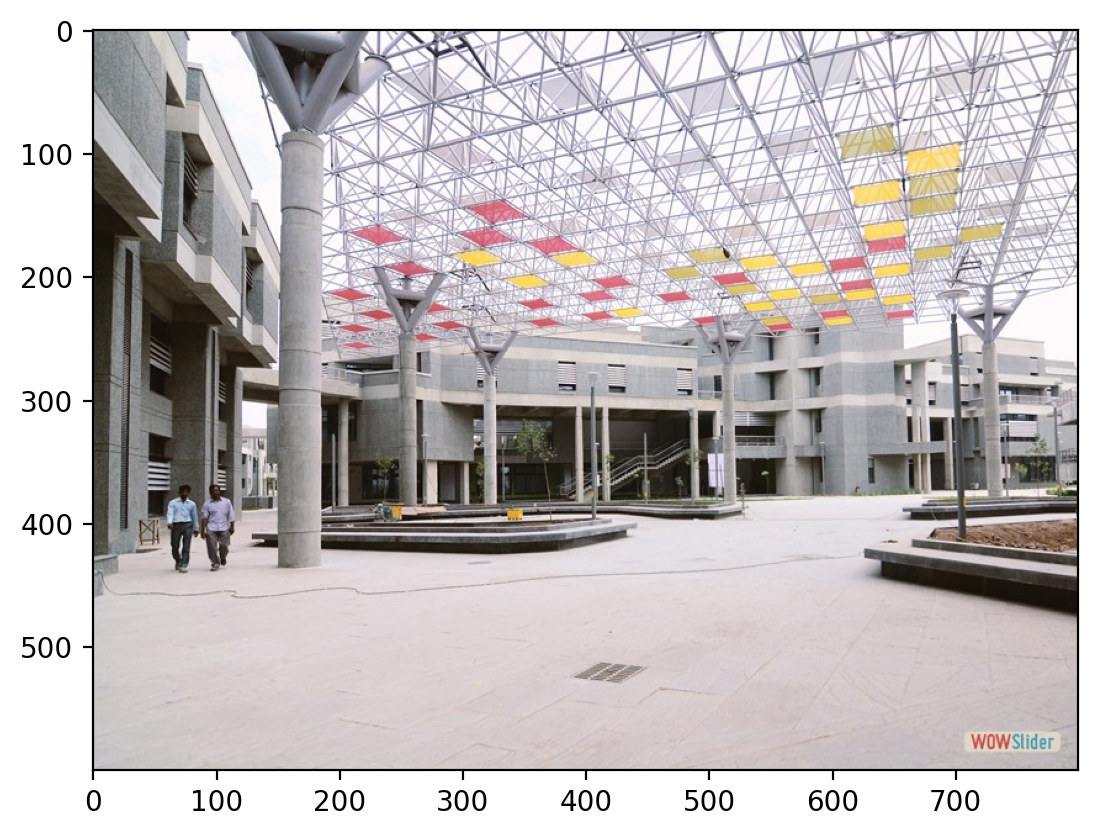

In [2]:
img = torchvision.io.read_image("/kaggle/input/sample-files/samvad.jpg")
print(img.shape)

plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [3]:
# Scaling down the image values to 0-1 using min-max scaler

from sklearn import preprocessing
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled).float().to(device)
print(img_scaled.shape)
print(img_scaled.max(), img_scaled.min())

torch.Size([3, 600, 800])
tensor(1.) tensor(0.)


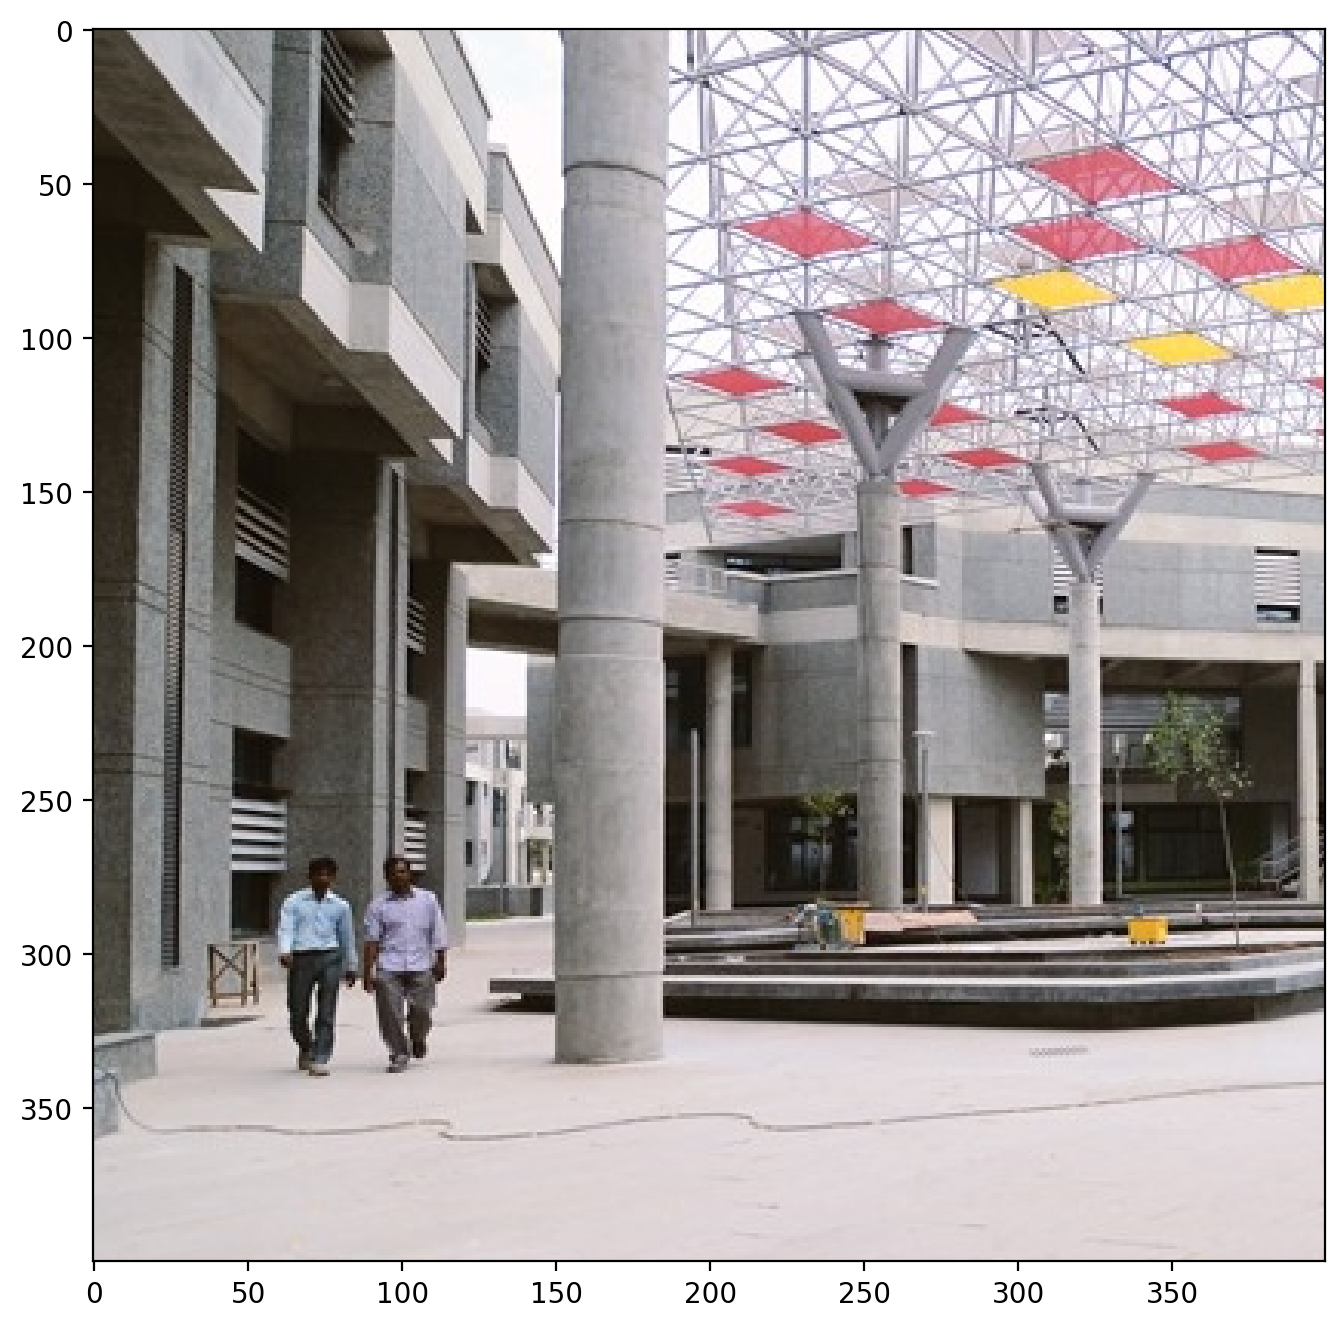

In [4]:
# Cropping the original image into a 400x400 resolution
img_400 = transforms.functional.crop(img.cpu(), 100, 0, 400, 400)
img_400.shape

plt.figure(figsize=(8, 8))
plt.imshow(rearrange(img_400, 'c h w -> h w c').cpu().numpy())

(200, 200, 3)


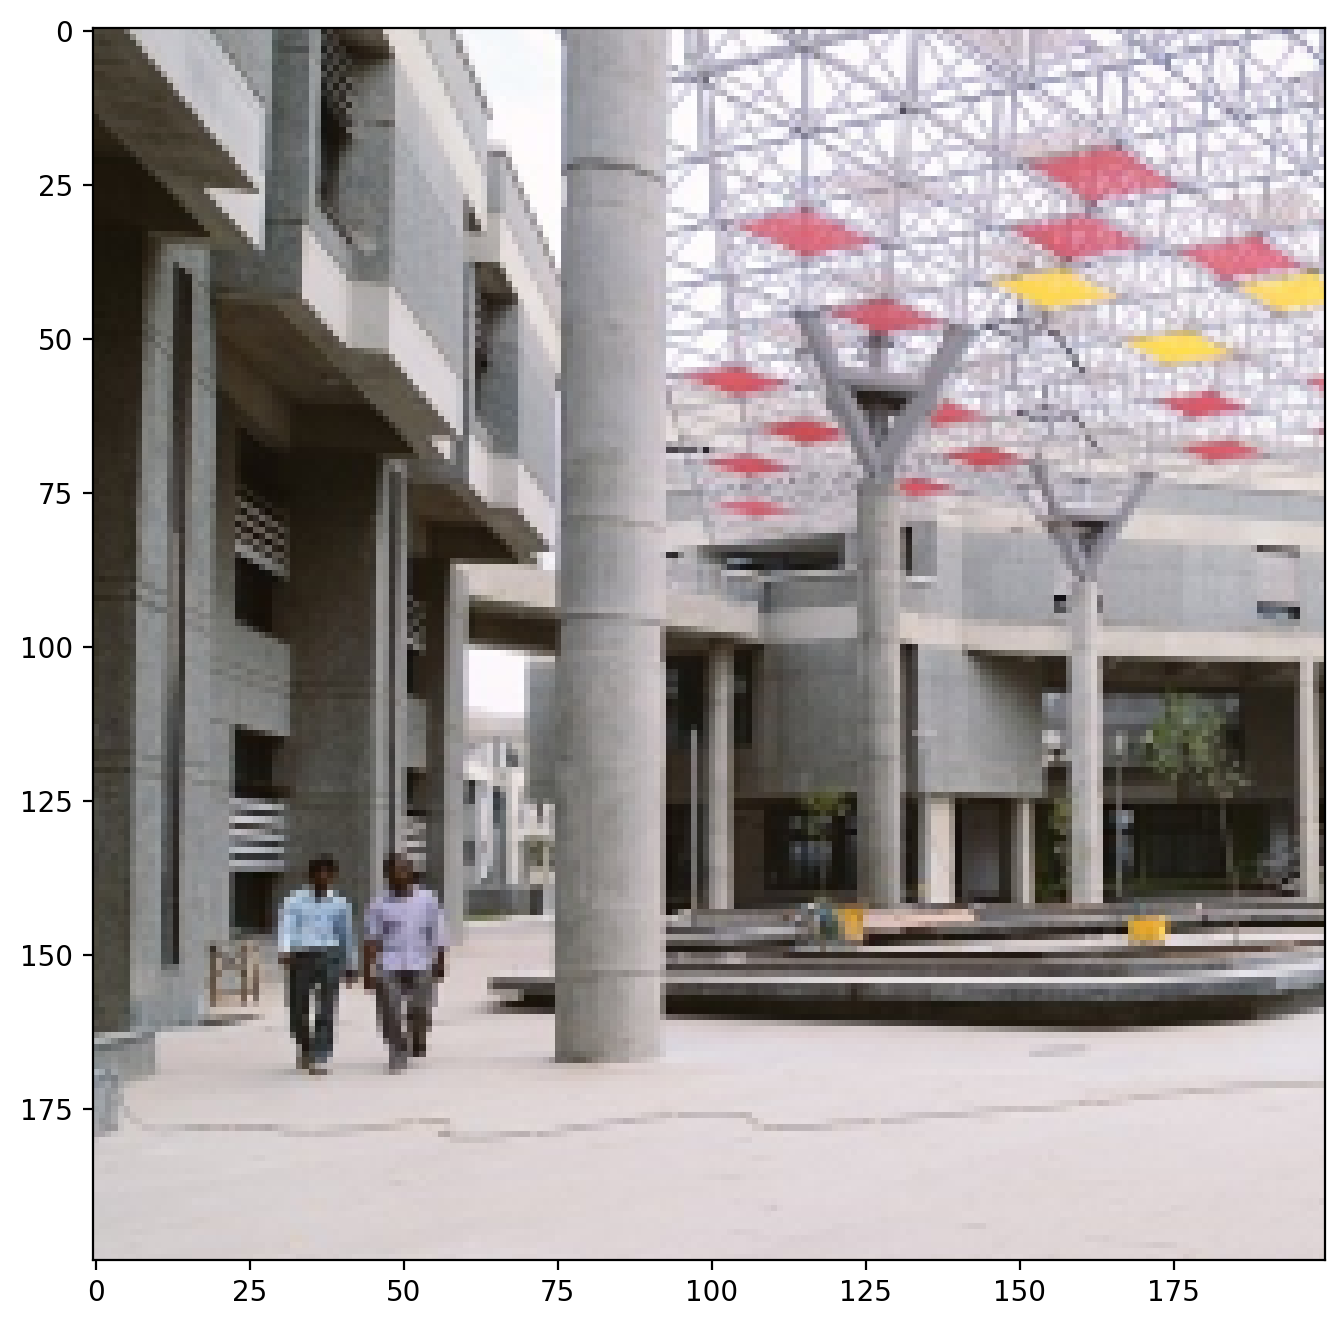

In [5]:
# Resizing the 400x400 to a 200x200 image

import cv2

img_200 = rearrange(img_400, 'c h w -> h w c').numpy()
img_200 = cv2.resize(img_200, (int(img_200.shape[1]*0.5), int(img_200.shape[0]*0.5)), interpolation = cv2.INTER_AREA)
print(img_200.shape)
plt.figure(figsize=(8, 8))
plt.imshow(img_200)


In [6]:
# Converting the 200x200 back to a torch.Tensor object
img_200 = torch.tensor(img_200, dtype=torch.float32).permute(2,0,1).to(device)
print(img_200.shape)
print(img_200.min(), img_200.max())

torch.Size([3, 200, 200])
tensor(3.) tensor(255.)


In [7]:
gc.collect()

585

In [8]:
# Function to create the coordinate map for the orginal image (maps the coordinates the their respective RGB values)

def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Scale the dimensions of the image
    height = int(height * scale)
    width = int(width * scale)

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> h w c').float()
    return X, Y

# Creating the Coordinate Map of the 200x200 image
X, Y = create_coordinate_map(img_200)
print("Shape of X =", X.shape, "\nShape of Y =", Y.shape)
print("Min of X =", X.min(), "Max of X =", X.max(), "\nMin of Y =", Y.min(), "Max of Y =", Y.max())


Shape of X = torch.Size([40000, 2]) 
Shape of Y = torch.Size([200, 200, 3])
Min of X = tensor(0.) Max of X = tensor(199.) 
Min of Y = tensor(3.) Max of Y = tensor(255.)


In [9]:
# Scaling X, Y using Min-Max Scaler
scaler = preprocessing.MinMaxScaler().fit(X.cpu())
scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)
print(scaled_X.shape)
print(scaled_X.max(), scaled_X.min())

Y = Y.view(-1, 3).to(device)  # Reshape Y to (40000, 3)
scaler_Y = preprocessing.MinMaxScaler().fit(Y.cpu())
scaled_Y = torch.tensor(scaler_Y.transform(Y.cpu())).float().to(device)
print(scaled_Y.shape)
print(scaled_Y.max(), scaled_Y.min())

torch.Size([40000, 2])
tensor(1.) tensor(0.)
torch.Size([40000, 3])
tensor(1.) tensor(0.)


In [10]:
# Defining the function to create RFF features

def create_rff_features(X, num_features, sigma):
    """
    X: torch.Tensor of shape (num_samples, 2)
    num_features: int
    sigma: float
    """
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=1)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device), rff

# Creating Random Fourier Features (RFF) of the 200x200 scaled_X

X_rff, rff = create_rff_features(scaled_X, 35000, 0.008)
print(X_rff.shape, X_rff.max(), X_rff.min())

torch.Size([40000, 35000]) tensor(0.0076) tensor(-0.0076)


In [11]:
# Defining our Linear Regression model

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

# Training the Linear Model on the Random Fourier Features

model = LinearModel(X_rff.shape[1], 3).to(device)
model

LinearModel(
  (linear): Linear(in_features=35000, out_features=3, bias=True)
)

In [12]:
# Defining the function to train the model

def train(model, lr, X, Y, epochs, verbose=True):
    """
    model: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss = {loss.item():.6f}")
    print("Final loss =", loss.item())

train(model, 0.02, X_rff, scaled_Y, 2000)

Epoch 0 loss = 0.418926
Epoch 100 loss = 0.003596
Epoch 200 loss = 0.003528
Epoch 300 loss = 0.003508
Epoch 400 loss = 0.003497
Epoch 500 loss = 0.003489
Epoch 600 loss = 0.003483
Epoch 700 loss = 0.003478
Epoch 800 loss = 0.003474
Epoch 900 loss = 0.003471
Epoch 1000 loss = 0.003468
Epoch 1100 loss = 0.003465
Epoch 1200 loss = 0.003463
Epoch 1300 loss = 0.003461
Epoch 1400 loss = 0.003459
Epoch 1500 loss = 0.003457
Epoch 1600 loss = 0.003455
Epoch 1700 loss = 0.003454
Epoch 1800 loss = 0.003452
Epoch 1900 loss = 0.003451
Final loss = 0.003449671436101198


In [13]:
import gc
del X_rff, X, Y, scaled_X, scaled_Y
gc.collect()

213

In [14]:
# Creating the Coordinate Map for the Super-Resolution Image (2x Scaled: 400 x 400)

X_2, Y_2 = create_coordinate_map(img_200, scale = 2)
print("Shape of X_2 =", X_2.shape, "\nShape of Y_2 =", Y_2.shape)
print("Min of X_2 =", X_2.min(), "Max of X_2 =", X_2.max(), "\nMin of Y_2 =", Y_2.min(), "Max of Y_2 =", Y_2.max())

Shape of X_2 = torch.Size([160000, 2]) 
Shape of Y_2 = torch.Size([200, 200, 3])
Min of X_2 = tensor(0.) Max of X_2 = tensor(399.) 
Min of Y_2 = tensor(3.) Max of Y_2 = tensor(255.)


In [15]:
# Scaling X_2, Y_2 using Min-Max Scaler

scaler = preprocessing.MinMaxScaler().fit(X_2.cpu())
scaled_X_2 = torch.tensor(scaler.transform(X_2.cpu())).float().to(device)
print(scaled_X_2.shape)
print(scaled_X_2.max(), scaled_X_2.min())

scaler_Y_2 = preprocessing.MinMaxScaler().fit(Y_2.view(-1, 3).cpu())
scaled_Y_2 = torch.tensor(scaler_Y_2.transform(Y_2.view(-1, 3).cpu())).float().to(device)

print(scaled_Y_2.shape)
print(scaled_Y_2.max(), scaled_Y_2.min())

torch.Size([160000, 2])
tensor(1.) tensor(0.)
torch.Size([40000, 3])
tensor(1.) tensor(0.)


In [16]:
# Transforming the scaled_X to the Random Fourier Features

X_rff = rff.transform(scaled_X_2.cpu().numpy())
X_rff = torch.tensor(X_rff).float().to(device)
print(X_rff.shape, X_rff.max(), X_rff.min())
print(X_rff)

torch.Size([160000, 35000]) tensor(0.0076) tensor(-0.0076)
tensor([[-0.0065,  0.0060, -0.0029,  ...,  0.0036, -0.0056, -0.0071],
        [-0.0019,  0.0049, -0.0050,  ...,  0.0015, -0.0050, -0.0073],
        [ 0.0039,  0.0036, -0.0065,  ..., -0.0007, -0.0043, -0.0075],
        ...,
        [-0.0070, -0.0003, -0.0075,  ...,  0.0062, -0.0075,  0.0071],
        [-0.0029, -0.0019, -0.0074,  ...,  0.0047, -0.0075,  0.0068],
        [ 0.0029, -0.0034, -0.0064,  ...,  0.0028, -0.0075,  0.0063]])


torch.Size([160000, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0692456..1.09499].


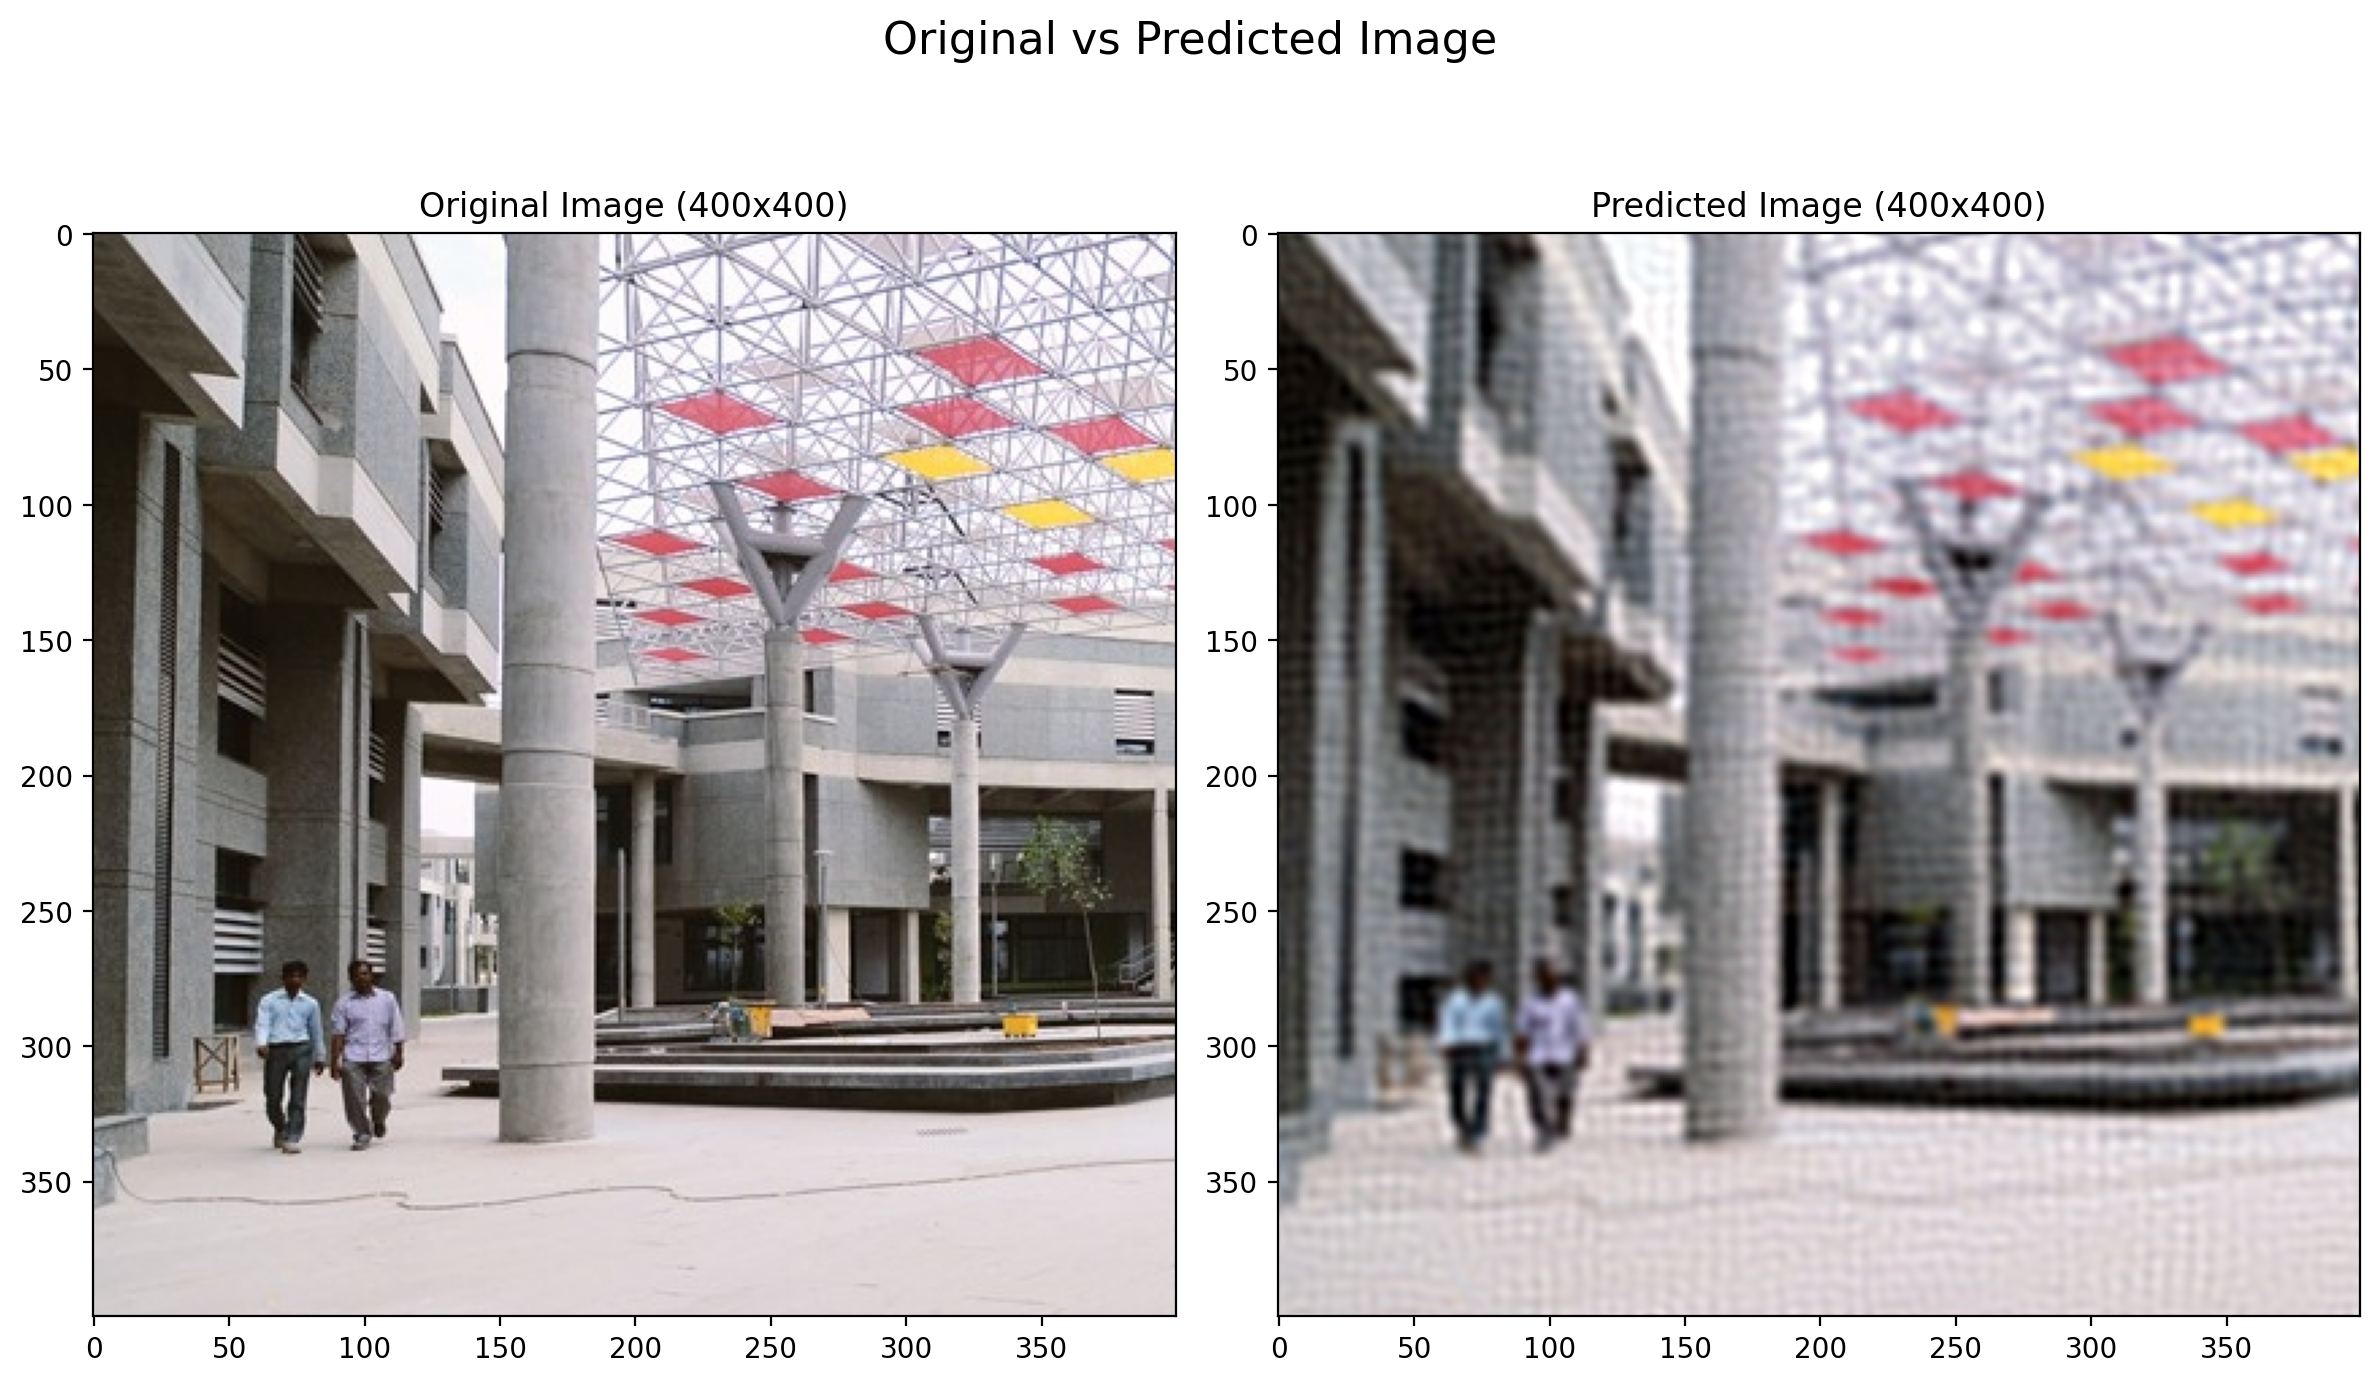

In [17]:
def plot_Original_vs_Predicted_Img(OriginalImg, X_rff_pred, net, return_Output = 0):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_pred: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape
    
    with torch.no_grad():
        outputs = net(X_rff_pred)
        pred_img = outputs.to(device)
        print(pred_img.shape)
        side = int(pred_img.shape[0] ** 0.5)
        pred_img = rearrange(pred_img, '(h w) c -> c h w', h=side, w=side)
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Image ({height}x{width})')
    ax1.imshow(rearrange(pred_img,'c h w -> h w c').cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Image',fontsize=16, y=0.95)
    plt.tight_layout()
    if(return_Output == 1):
        return pred_img

Y = plot_Original_vs_Predicted_Img(img_400, X_rff, model, return_Output = 1)

In [18]:
def RMSE(img1,img2):
    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))
    return rmse

def PSNR(RMSE, max_val=255):
    psnr = 20 * torch.log10(max_val / RMSE)
    return psnr.item()

Y = Y.to(device)
img_400 = img_400.to(device)

Y_np = rearrange(Y, 'c h w -> h w c').cpu().numpy().reshape(-1, 3)
Y_inv_scaled = scaler_img.inverse_transform(Y_np)
Y_inv_scaled = torch.tensor(Y_inv_scaled).reshape(400, 400, 3).permute(2, 0, 1).to(device)

rmse = RMSE(img_400, Y_inv_scaled)
psnr = PSNR(rmse)

print(f"RMSE: {rmse.item():.6f}")
print(f"PSNR: {psnr:.6f} dB")

RMSE: 21.394695
PSNR: 21.524681 dB
